<a href="https://colab.research.google.com/github/Phani69/Pattern_Vibration_NASA_Bearing_Datasets/blob/main/Predictive_maintanence.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Libraries

In [ ]:
import pandas as pd
import glob
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import smtplib
import os
import pickle
import tensorflow as tf
import keras
import warnings
warnings.filterwarnings('ignore')

In [ ]:
from scipy.fft import fft, fftfreq
from scipy.signal import find_peaks
from pathlib import Path
from typing import Callable
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from scipy.io import loadmat
from email.mime.text import MIMEText
from email.mime.multipart import MIMEMultipart
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.metrics import precision_score, recall_score, roc_auc_score

In [ ]:
from tensorflow.keras import layers, losses
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import layers, losses
from plotly.subplots import make_subplots
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.decomposition import KernelPCA

# Read Data

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("vinayak123tyagi/bearing-dataset")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/bearing-dataset


In [ ]:
import os
import shutil

# Define the name of the new folder
new_folder_name = "bearing_dataset_extracted"

# Create the new folder
os.makedirs(new_folder_name, exist_ok=True)

# Define the source directory (where the files were unzipped)
source_dir = "/root/.cache/kagglehub/datasets/vinayak123tyagi/bearing-dataset/versions/1/"

# List all files and directories in the source directory
items_to_move = os.listdir(source_dir)

# Move each item to the new folder
for item in items_to_move:
    shutil.move(os.path.join(source_dir, item), os.path.join(new_folder_name, item))

print(f"Extracted files moved to: {new_folder_name}")

Extracted files moved to: bearing_dataset_extracted


In [ ]:
data_folder = Path("/content/bearing_dataset_extracted/")

In [ ]:
dataset_foler_prefix = "2nd" # Keep the prefix definition if it's used elsewhere
dataset_folder = Path("/content/bearing_dataset_extracted/2nd_test/2nd_test")

In [ ]:
data_paths = sorted(dataset_folder.glob("*"))
len(data_paths)

984

# Calculate RMS

In [ ]:
def calculate_rms(signal):
    return np.sqrt(np.mean(np.square(signal)))

rms_list = []

for file in data_paths:
    d = pd.read_csv(file, delimiter='\t', header=None)

    if d.shape[1] == 1:
        d = d[0].str.split("\t", expand=True)


    d.columns = ['Bearing 1', 'Bearing 2', 'Bearing 3', 'Bearing 4']

    num_rows = len(d)
    selected_data = d.iloc[:min(20480, num_rows)]

    timestamp = file.stem
    timeatemp = timestamp.replace("_",":")
    timestamp = pd.to_datetime(timestamp, errors="coerce")

    Rms_values = {
        "Timestamp": file.stem,
        "RMS Bearing 1": calculate_rms(selected_data["Bearing 1"]),
        "RMS Bearing 2": calculate_rms(selected_data["Bearing 2"]),
        "RMS Bearing 3": calculate_rms(selected_data["Bearing 3"]),
        "RMS Bearing 4": calculate_rms(selected_data["Bearing 4"])
    }

    rms_list.append(Rms_values)

rms_df = pd.DataFrame(rms_list)

print(rms_df)

            Timestamp  RMS Bearing 1  RMS Bearing 2  RMS Bearing 3  \
0    2004.02.12.10.32       0.074179       0.090944       0.109404   
1    2004.02.12.10.42       0.075382       0.093419       0.109817   
2    2004.02.12.10.52       0.076230       0.093718       0.109861   
3    2004.02.12.11.02       0.078724       0.092947       0.110667   
4    2004.02.12.11.12       0.078474       0.095348       0.107506   
..                ...            ...            ...            ...   
979  2004.02.19.05.42       0.725001       0.218294       0.170577   
980  2004.02.19.05.52       0.462012       0.170817       0.177878   
981  2004.02.19.06.02       0.483835       0.193641       0.187405   
982  2004.02.19.06.12       0.002103       0.004018       0.003950   
983  2004.02.19.06.22       0.001533       0.001239       0.001197   

     RMS Bearing 4  
0         0.054103  
1         0.056101  
2         0.056145  
3         0.056807  
4         0.056841  
..             ...  
979       0.

In [ ]:
rms_df

,Timestamp,RMS Bearing 1,RMS Bearing 2,RMS Bearing 3,RMS Bearing 4
0,2004.02.12.10.32,0.074179,0.090944,0.109404,0.054103
1,2004.02.12.10.42,0.075382,0.093419,0.109817,0.056101
2,2004.02.12.10.52,0.076230,0.093718,0.109861,0.056145
3,2004.02.12.11.02,0.078724,0.092947,0.110667,0.056807
4,2004.02.12.11.12,0.078474,0.095348,0.107506,0.056841
...,...,...,...,...,...
979,2004.02.19.05.42,0.725001,0.218294,0.170577,0.148351
980,2004.02.19.05.52,0.462012,0.170817,0.177878,0.116630
981,2004.02.19.06.02,0.483835,0.193641,0.187405,0.130582
982,2004.02.19.06.12,0.002103,0.004018,0.003950,0.002154


Text(0, 0.5, 'Amplitude')

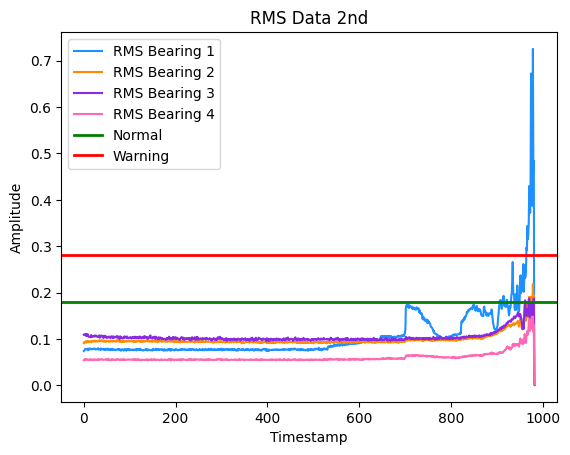

In [ ]:
rms_df["RMS Bearing 1"].plot(color='dodgerblue')
rms_df["RMS Bearing 2"].plot(color='darkorange')
rms_df["RMS Bearing 3"].plot(color='blueviolet')
rms_df["RMS Bearing 4"].plot(color='hotpink')
plt.axhline(y=0.18, color='green', linestyle='-', linewidth=2, label='Normal')
plt.axhline(y=0.28, color='Red', linestyle='-', linewidth=2, label='Warning')
plt.style.use('default')
plt.legend()
plt
plt.title("RMS Data 2nd")
plt.xlabel("Timestamp")
plt.ylabel("Amplitude")

# Train and Test Random Forest Model

In [ ]:
Target = ['RMS Bearing 1','RMS Bearing 2','RMS Bearing 3','RMS Bearing 4']

rms_df['Target'] = rms_df[Target].gt(0.14).any(axis=1).astype(int)

rms_df

,Timestamp,RMS Bearing 1,RMS Bearing 2,RMS Bearing 3,RMS Bearing 4,Target
0,2004.02.12.10.32,0.074179,0.090944,0.109404,0.054103,0
1,2004.02.12.10.42,0.075382,0.093419,0.109817,0.056101,0
2,2004.02.12.10.52,0.076230,0.093718,0.109861,0.056145,0
3,2004.02.12.11.02,0.078724,0.092947,0.110667,0.056807,0
4,2004.02.12.11.12,0.078474,0.095348,0.107506,0.056841,0
...,...,...,...,...,...,...
979,2004.02.19.05.42,0.725001,0.218294,0.170577,0.148351,1
980,2004.02.19.05.52,0.462012,0.170817,0.177878,0.116630,1
981,2004.02.19.06.02,0.483835,0.193641,0.187405,0.130582,1
982,2004.02.19.06.12,0.002103,0.004018,0.003950,0.002154,0


In [ ]:
rms_df['Target'].value_counts()

,count
Target,
0,796
1,188


In [ ]:
features = ['RMS Bearing 1','RMS Bearing 2','RMS Bearing 3','RMS Bearing 4']
x = rms_df.loc[:, features]
y = rms_df.loc[:,['Target']]

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=0.2, random_state=21)

rf_clf = RandomForestClassifier(n_estimators=100 , random_state=21)

In [ ]:
rf_clf.fit(x_train, y_train.values.ravel())

RandomForestClassifier(random_state=21)

In [ ]:
y_pred = rf_clf.predict(x_test)
y_pred

array([1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0,
       1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0])

In [ ]:
print('Training set score: {:.2f}'.format(rf_clf.score(x_train, y_train)))

print('Test set score: {:.2f}'.format(rf_clf.score(x_test, y_test)))

Training set score: 1.00
Test set score: 1.00


In [ ]:
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy: 1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       159
           1       1.00      1.00      1.00        38

    accuracy                           1.00       197
   macro avg       1.00      1.00      1.00       197
weighted avg       1.00      1.00      1.00       197



<Axes: >

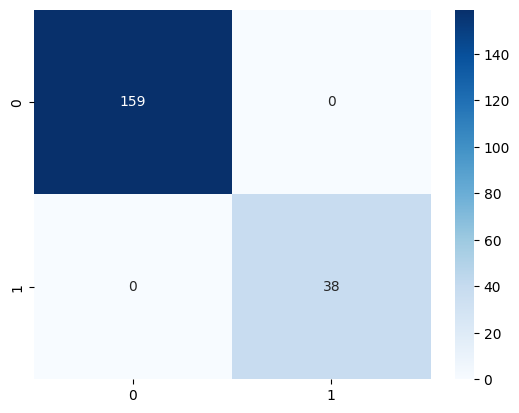

In [ ]:
Cm = confusion_matrix(y_test, y_pred)
sns.heatmap(Cm, annot=True, cmap='Blues', fmt='.0f')

In [ ]:
pickle.dump(rf_clf, open("rf_model1.pkl", 'wb'))

In [ ]:
load_model = pickle.load(open("rf_model1.pkl",'rb'))

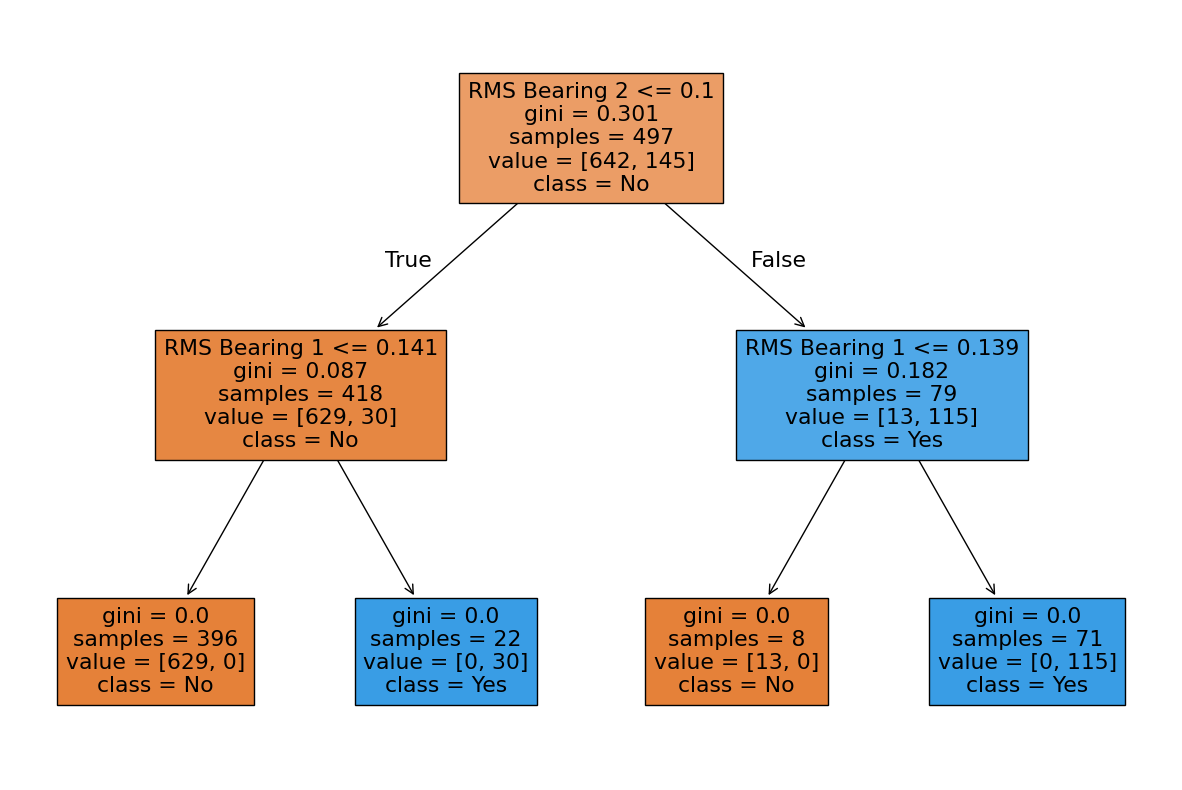

In [ ]:
from sklearn import tree
plt.figure(figsize=(15, 10))  # ขยายขนาดภาพ
tree.plot_tree(rf_clf.estimators_[99],
               filled=True,   # เติมสีตาม class
               feature_names=features,  # แสดงชื่อ feature จริง
               class_names=["No", "Yes"])    # ชื่อ class สวย ๆ
plt.show()


#FFT (Fast fourier Transform)

In [ ]:
import warnings
warnings.filterwarnings('ignore')

fs = 20000
T = 1/fs

base_path = Path("/content/bearing_dataset_extracted/2nd_test/2nd_test")

all_rows = []

for path in base_path.rglob("*"):
    if path.is_file():
        label = path.parent.name
        try:
            try:
                data = pd.read_csv(path, delim_whitespace=True, header=None)
            except:
                data = pd.read_csv(path, delimiter='\t', header=None)

            if data.shape[1] >= 4:
                signal = data.values
                N = signal.shape[0]
                xf = fftfreq(N, T)[:N // 2]

                for ch in range(0, signal.shape[1]):
                    raw = signal[:, ch]
                    yf = fft(raw)
                    mag = 2.0 / N * np.abs(yf[:N // 2])

                    row = {
                        'filename': path.name,
                        'channel': f'ch{ch}'
                    }

                    for i, freq in enumerate(xf):
                        row[f'{freq:.2f}'] = round(mag[i], 4)

                    all_rows.append(row)

        except Exception as e:
            print()

df = pd.DataFrame(all_rows)

df.set_index(['filename', 'channel'], inplace=True)
df.columns = [f"{freq:.2f}" for freq in xf]

In [ ]:
df

0.00    0.98    1.95    2.93    3.91    4.88  \
filename            channel                                                   
2004.02.13.05.22.39 ch0      0.0042  0.0004  0.0004  0.0005  0.0001  0.0003   
                    ch1      0.0032  0.0007  0.0002  0.0005  0.0001  0.0010   
                    ch2      0.0042  0.0002  0.0012  0.0006  0.0013  0.0015   
                    ch3      0.0054  0.0007  0.0007  0.0001  0.0002  0.0004   
2004.02.16.03.52.39 ch0      0.0034  0.0009  0.0005  0.0007  0.0008  0.0008   
...                             ...     ...     ...     ...     ...     ...   
2004.02.17.05.42.39 ch3      0.0053  0.0009  0.0011  0.0005  0.0004  0.0006   
2004.02.15.02.32.39 ch0      0.0030  0.0003  0.0006  0.0005  0.0000  0.0004   
                    ch1      0.0032  0.0009  0.0005  0.0009  0.0009  0.0003   
                    ch2      0.0036  0.0017  0.0005  0.0013  0.0011  0.0006   
                    ch3      0.0053  0.0007  0.0004  0.0004  0.0003  0.0005   

                               5.86    6.84    7.81    8.79  ...  9990.23  \
filename            channel                                  ...            
2004.02.13.05.22.39 ch0      0.0003  0.0002  0.0004  0.0003  ...   0.0003   
                    ch1      0.0005  0.0008  0.0013  0.0004  ...   0.0003   
                    ch2      0.0013  0.0004  0.0011  0.0017  ...   0.0000   
                    ch3      0.0004  0.0003  0.0003  0.0004  ...   0.0005   
2004.02.16.03.52.39 ch0      0.0003  0.0006  0.0003  0.0003  ...   0.0004   
...                             ...     ...     ...     ...  ...      ...   
2004.02.17.05.42.39 ch3      0.0002  0.0004  0.0005  0.0005  ...   0.0003   
2004.02.15.02.32.39 ch0      0.0005  0.0001  0.0005  0.0006  ...   0.0001   
                    ch1      0.0007  0.0001  0.0002  0.0005  ...   0.0005   
                    ch2      0.0007  0.0006  0.0003  0.0001  ...   0.0001   
                    ch3      0.0002  0.0000  0.0004  0.0006  ...   0.0003   

                             9991.21  9992.19  9993.16  9994.14  9995.12  \
filename            channel                                                
2004.02.13.05.22.39 ch0       0.0001   0.0002   0.0002   0.0002   0.0002   
                    ch1       0.0002   0.0005   0.0005   0.0006   0.0004   
                    ch2       0.0006   0.0007   0.0003   0.0009   0.0005   
                    ch3       0.0005   0.0003   0.0001   0.0002   0.0002   
2004.02.16.03.52.39 ch0       0.0003   0.0006   0.0002   0.0003   0.0003   
...                              ...      ...      ...      ...      ...   
2004.02.17.05.42.39 ch3       0.0002   0.0006   0.0007   0.0001   0.0001   
2004.02.15.02.32.39 ch0       0.0002   0.0004   0.0004   0.0003   0.0002   
                    ch1       0.0001   0.0002   0.0006   0.0005   0.0008   
                    ch2       0.0004   0.0003   0.0002   0.0004   0.0006   
                    ch3       0.0003   0.0001   0.0006   0.0002   0.0004   

                             9996.09  9997.07  9998.05  9999.02  
filename            channel                                      
2004.02.13.05.22.39 ch0       0.0002   0.0001   0.0002   0.0004  
                    ch1       0.0002   0.0008   0.0001   0.0002  
                    ch2       0.0001   0.0007   0.0002   0.0002  
                    ch3       0.0004   0.0004   0.0001   0.0005  
2004.02.16.03.52.39 ch0       0.0001   0.0003   0.0004   0.0004  
...                              ...      ...      ...      ...  
2004.02.17.05.42.39 ch3       0.0006   0.0002   0.0003   0.0004  
2004.02.15.02.32.39 ch0       0.0003   0.0002   0.0003   0.0005  
                    ch1       0.0005   0.0003   0.0003   0.0001  
                    ch2       0.0008   0.0002   0.0008   0.0006  
                    ch3       0.0005   0.0005   0.0005   0.0004  

[3936 rows x 10240 columns]

In [ ]:
df = df.reset_index()
df['Target'] = df['channel'].apply(lambda x: 1 if x == 'ch0'and'ch2' else 0)
df = df.set_index(['filename', 'channel'])

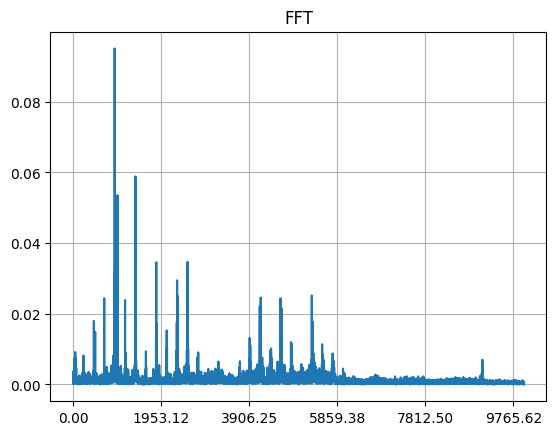

In [ ]:
df.loc["2004.02.19.04.52.39"].loc['ch1'].plot()
plt.title("FFT")
plt.grid()

In [ ]:
label = df['Target'].to_numpy()
data = df.drop(['Target'], axis=1).to_numpy()
train_data, test_data, train_label, test_label = train_test_split(
    data, label, test_size=0.2, random_state=21
)

# Train Auto-Encoder Model

In [ ]:
min_val = tf.reduce_min(train_data)
max_val = tf.reduce_max(train_data)

train_data = (train_data - min_val) / (max_val - min_val)
test_data = (test_data - min_val) / (max_val - min_val)

train_data = tf.cast(train_data, tf.float32)
test_data = tf.cast(test_data, tf.float32)

In [ ]:
train_label = train_label.astype(bool)
test_label = test_label.astype(bool)

normal_train_data = train_data[train_label]
normal_test_data = test_data[test_label]

anomalous_train_data = train_data[~train_label]
anomalous_test_data = test_data[~test_label]

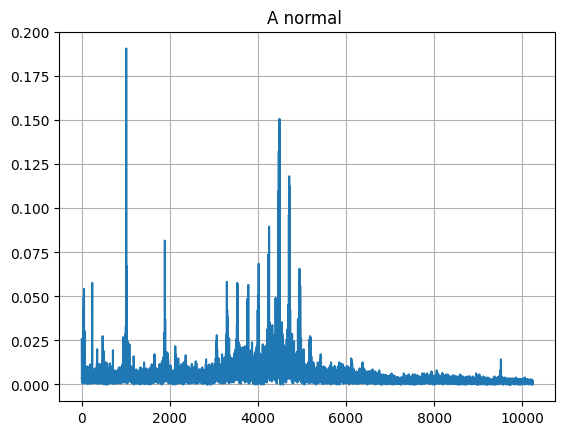

In [ ]:
plt.grid()
plt.plot(np.arange(10240), normal_train_data[0])
plt.title("A normal ")
plt.show()

#Plot Anomalous Data

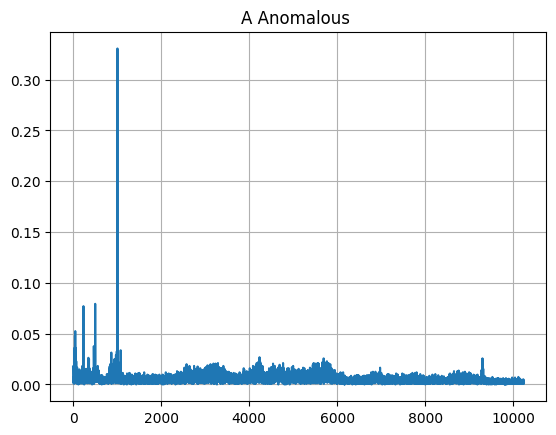

In [ ]:
plt.grid()
plt.plot(np.arange(10240), anomalous_train_data[0])
plt.title("A Anomalous ")
plt.show()


#Build the model

In [ ]:
class AnomalyDetector(Model):
    def __init__(self):
        super(AnomalyDetector,self).__init__()
        self.encoder = tf.keras.Sequential([
            layers.Dense(32, activation="relu"),
            layers.Dense(16, activation="relu"),
            layers.Dense(8, activation="relu")])

        self.decoder = tf.keras.Sequential([
            layers.Dense(16, activation="relu"),
            layers.Dense(32, activation="relu"),
            layers.Dense(10240, activation="sigmoid")])

    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

autoencoder = AnomalyDetector()

In [ ]:
autoencoder.compile(optimizer='adam', loss='mae')

In [ ]:
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights = True
)

In [ ]:
tf.random.set_seed(21)

In [ ]:
history = autoencoder.fit(normal_train_data, normal_train_data,
          epochs=100,
          batch_size=1024,
          validation_data=(test_data, test_data),
          callbacks=[early_stopping],
          shuffle=True)

Epoch 1/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - loss: 0.4947 - val_loss: 0.4947
Epoch 2/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 433ms/step - loss: 0.4944 - val_loss: 0.4944
Epoch 3/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 369ms/step - loss: 0.4942 - val_loss: 0.4942
Epoch 4/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 613ms/step - loss: 0.4940 - val_loss: 0.4940
Epoch 5/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 298ms/step - loss: 0.4937 - val_loss: 0.4937
Epoch 6/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 314ms/step - loss: 0.4935 - val_loss: 0.4935
Epoch 7/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 363ms/step - loss: 0.4932 - val_loss: 0.4932
Epoch 8/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 373ms/step - loss: 0.4930 - val_loss: 0.4930
Epoch 9/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 319ms/step - loss: 0.4927 - val_loss: 0.4927
Epoch 10/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 611ms/step - loss: 0.4925 - val_loss: 0.4924
Epoch 11/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 478ms/step - loss: 0.4922 - val_loss: 0.4921
Epoch 12/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 578ms/step - loss: 0.4919

Text(0.5, 1.0, 'MAE Loss')

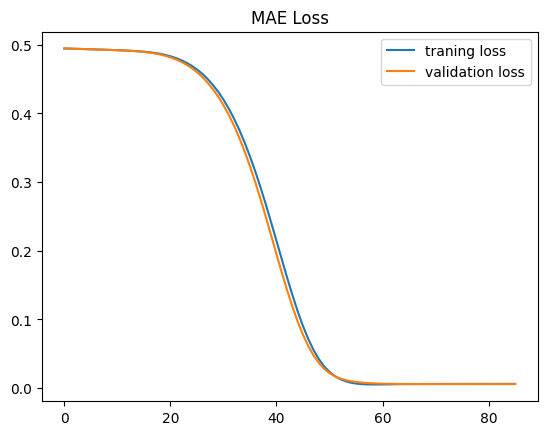

In [ ]:
plt.plot(history.history["loss"], label="traning loss")
plt.plot(history.history["val_loss"], label="validation loss")
plt.legend()
plt.title("MAE Loss")

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


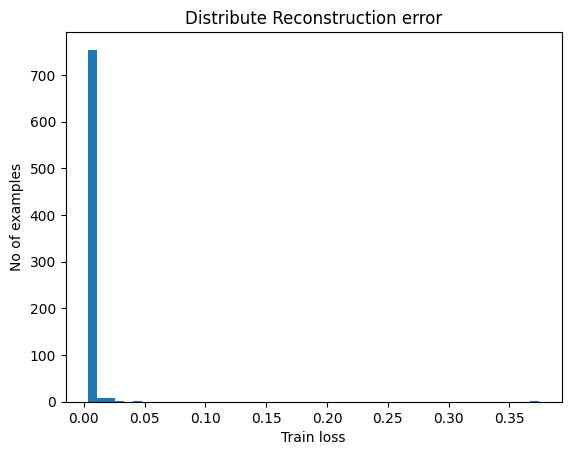

In [ ]:
reconstructions = autoencoder.predict(normal_train_data)
train_loss = tf.keras.losses.mae(reconstructions, normal_train_data)

plt.hist(train_loss[None,:], bins=50)
plt.xlabel("Train loss")
plt.ylabel("No of examples")
plt.title("Distribute Reconstruction error")
plt.show()

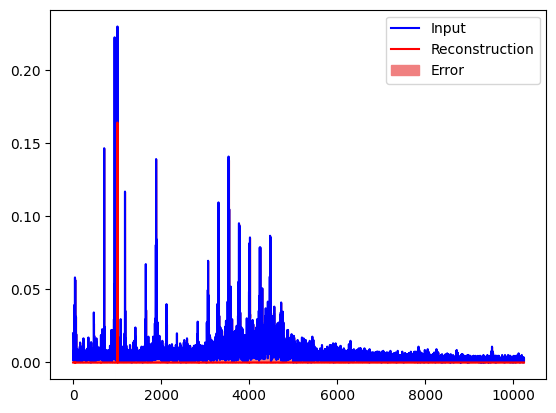

In [ ]:
encoded_data = autoencoder.encoder(normal_test_data).numpy()
decoded_data = autoencoder.decoder(encoded_data).numpy()

plt.plot(normal_test_data[0],'b')
plt.plot(decoded_data[0], 'r')
plt.fill_between(np.arange(10240), decoded_data[0], normal_test_data[0], color='lightcoral')
plt.legend(labels=["Input", "Reconstruction", "Error"])
plt.show()

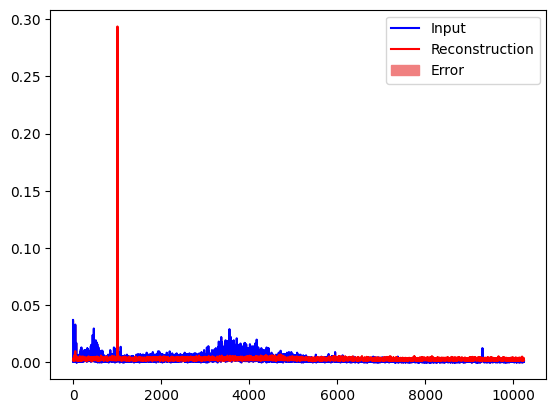

In [ ]:
encoded_data = autoencoder.encoder(anomalous_test_data).numpy()
decoded_data = autoencoder.decoder(encoded_data).numpy()

plt.plot(anomalous_test_data[0],'b')
plt.plot(decoded_data[0], 'r')
plt.fill_between(np.arange(10240), decoded_data[0], anomalous_test_data[0], color='lightcoral')
plt.legend(labels=["Input", "Reconstruction", "Error"])
plt.show()

In [ ]:
threshold = np.mean(train_loss) + (np.std(train_loss))*2
print("Threshold: ", threshold)

Threshold:  0.04398448


25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


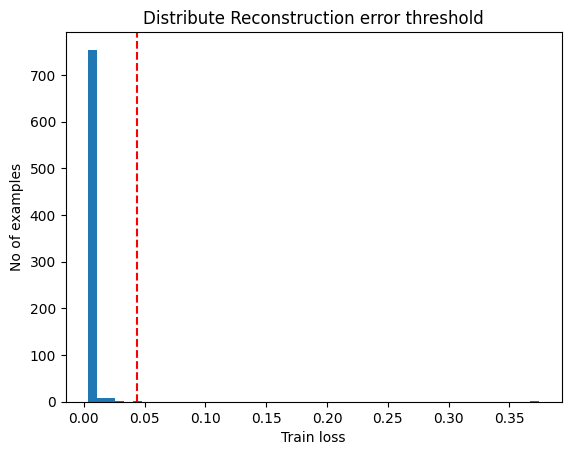

In [ ]:
reconstructions = autoencoder.predict(normal_train_data)
train_loss = tf.keras.losses.mae(reconstructions, normal_train_data)

plt.hist(train_loss[None,:], bins=50)
plt.axvline(threshold, color= 'r', linestyle='--')
plt.xlabel("Train loss")
plt.ylabel("No of examples")
plt.title("Distribute Reconstruction error threshold")
plt.show()

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


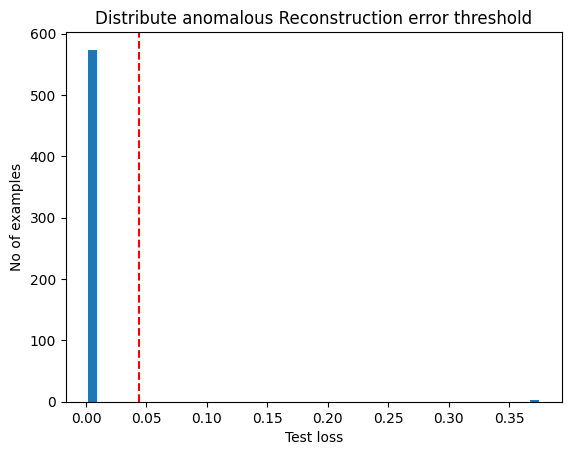

In [ ]:
reconstructions = autoencoder.predict(anomalous_test_data)
test_loss = tf.keras.losses.mae(reconstructions, anomalous_test_data)

plt.hist(test_loss[None, :], bins=50)
plt.axvline(threshold, color= 'r', linestyle='--')
plt.xlabel("Test loss")
plt.ylabel("No of examples")
plt.title("Distribute anomalous Reconstruction error threshold")
plt.show()

In [ ]:
def predict(model, data, threshold):
  reconstructions = model(data)
  loss = tf.keras.losses.mae(reconstructions, data)
  return tf.math.less(loss, threshold)

def print_stats(predictions, labels):
  print("Accuracy = {}".format(accuracy_score(labels, predictions)))
  print("Precision = {}".format(precision_score(labels, predictions)))
  print("Recall = {}".format(recall_score(labels, predictions)))

In [ ]:
preds = predict(autoencoder, test_data, threshold)
print_stats(preds, test_label)

Accuracy = 0.2715736040609137
Precision = 0.2697201017811705
Recall = 1.0



#LSTM Model Forecast

In [ ]:
imputer = SimpleImputer(missing_values=np.nan)  # Handling missing values
rms_df.drop(columns=['Timestamp'], inplace=True)
dataFrame = pd.DataFrame(imputer.fit_transform(rms_df), columns=rms_df.columns)
dataFrame = dataFrame.reset_index(drop=True)
# Applying feature scaling
scaler = MinMaxScaler(feature_range=(0, 1))
df_scaled = scaler.fit_transform(dataFrame.to_numpy())
df_scaled = pd.DataFrame(df_scaled, columns=list(dataFrame.columns))
target_scaler = MinMaxScaler(feature_range=(0, 1))
df_scaled[['RMS Bearing 1','RMS Bearing 2','RMS Bearing 3','RMS Bearing 4']] = target_scaler.fit_transform(dataFrame[['RMS Bearing 1','RMS Bearing 2','RMS Bearing 3','RMS Bearing 4']].to_numpy())
df_scaled = df_scaled.astype(float)

In [ ]:
# Single step dataset preparation
def singleStepSampler(df, window):
    xRes = []
    yRes = []
    for i in range(0, len(df) - window):
        res = []
        for j in range(0, window):
            r = []
            for col in df.columns:
                r.append(df[col][i + j])
            res.append(r)
        xRes.append(res)
        yRes.append(df[['RMS Bearing 1','RMS Bearing 2','RMS Bearing 3','RMS Bearing 4']].iloc[i + window].values)
    return np.array(xRes), np.array(yRes)

In [ ]:
# Dataset splitting
SPLIT = 0.80
(xVal, yVal) = singleStepSampler(df_scaled, 20)
X_train = xVal[:int(SPLIT * len(xVal))]
y_train = yVal[:int(SPLIT * len(yVal))]
X_test = xVal[int(SPLIT * len(xVal)):]
y_test = yVal[int(SPLIT * len(yVal)):]

In [ ]:
multivariate_lstm = keras.Sequential()
multivariate_lstm.add(keras.layers.LSTM(200, input_shape=(X_train.shape[1], X_train.shape[2])))
multivariate_lstm.add(keras.layers.Dropout(0.2))
multivariate_lstm.add(keras.layers.Dense(4, activation='linear'))
multivariate_lstm.compile(loss = 'MeanSquaredError', metrics=['MAE'], optimizer='Adam')
multivariate_lstm.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 200)            │       164,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 200)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 4)              │           804 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 165,604 (646.89 KB)

 Trainable params: 165,604 (646.89 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history = multivariate_lstm.fit(X_train, y_train, epochs=20)

Epoch 1/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - MAE: 0.1718 - loss: 0.0564
Epoch 2/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - MAE: 0.0343 - loss: 0.0019
Epoch 3/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - MAE: 0.0290 - loss: 0.0013
Epoch 4/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - MAE: 0.0279 - loss: 0.0013
Epoch 5/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - MAE: 0.0261 - loss: 0.0011
Epoch 6/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - MAE: 0.0251 - loss: 0.0010
Epoch 7/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - MAE: 0.0252 - loss: 9.9803e-04
Epoch 8/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - MAE: 0.0232 - loss: 8.5596e-04
Epoch 9/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 64ms/step - MAE: 0.0233 - loss: 8.8526e-04
Epoch 10/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - MAE: 0.0232 - loss: 8.3856e-04
Epoch 11/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - MAE: 0.0231 - loss: 8.3969e-04
Epoch 12/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - MAE: 0.0226 - loss: 8.3385e-04
Epoch 13/20
2

In [ ]:
def calculate_rms(signal):
    return np.sqrt(np.mean(np.square(signal)))

rms_list = []

for file in data_paths[:960]:
    d2 = pd.read_csv(file, delimiter='\t', header=None)

    if d2.shape[1] == 1:
        d2 = d2[0].str.split("\t", expand=True)


    d2.columns = ['Bearing 1', 'Bearing 2', 'Bearing 3', 'Bearing 4']

    num_rows = len(d2)
    selected_data = d2.iloc[:min(20480, num_rows)]

    timestamp = file.stem
    timeatemp = timestamp.replace("_",":")
    timestamp = pd.to_datetime(timestamp, errors="coerce")

    Rms_values = {
        "Timestamp": file.stem,
        "RMS Bearing 1": calculate_rms(selected_data["Bearing 1"]),
        "RMS Bearing 2": calculate_rms(selected_data["Bearing 2"]),
        "RMS Bearing 3": calculate_rms(selected_data["Bearing 3"]),
        "RMS Bearing 4": calculate_rms(selected_data["Bearing 4"])
    }

    rms_list.append(Rms_values)

rms_df2 = pd.DataFrame(rms_list)

print(rms_df2.head())

          Timestamp  RMS Bearing 1  RMS Bearing 2  RMS Bearing 3  \
0  2004.02.12.10.32       0.074179       0.090944       0.109404   
1  2004.02.12.10.42       0.075382       0.093419       0.109817   
2  2004.02.12.10.52       0.076230       0.093718       0.109861   
3  2004.02.12.11.02       0.078724       0.092947       0.110667   
4  2004.02.12.11.12       0.078474       0.095348       0.107506   

   RMS Bearing 4  
0       0.054103  
1       0.056101  
2       0.056145  
3       0.056807  
4       0.056841  


In [ ]:
rms_df2.set_index('Timestamp', inplace=True)

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


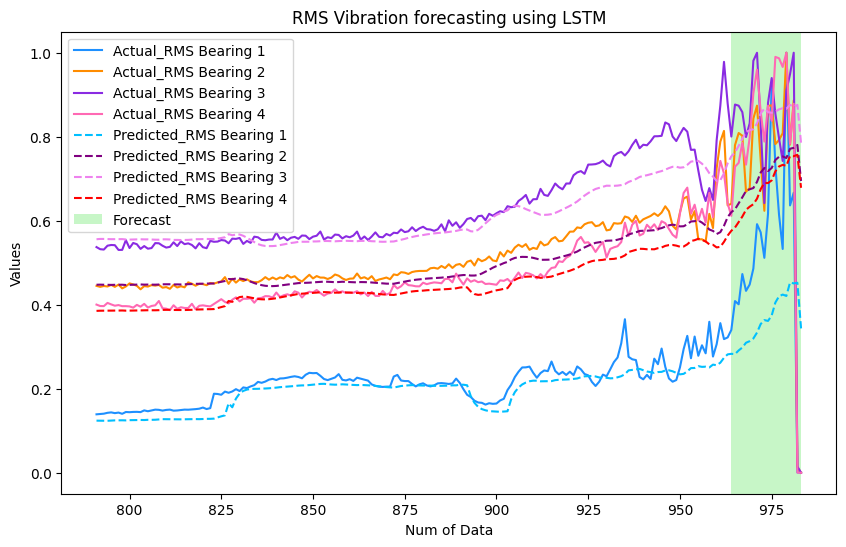

In [ ]:
# Forecast Plot with Dates on X-axis
predicted_values = multivariate_lstm.predict(X_test)

d = {
    'Predicted_RMS Bearing 1': predicted_values[:, 0],
    'Predicted_RMS Bearing 2': predicted_values[:, 1],
    'Predicted_RMS Bearing 3': predicted_values[:, 2],
    'Predicted_RMS Bearing 4': predicted_values[:, 3],
    'Actual_RMS Bearing 1': y_test[:, 0],
    'Actual_RMS Bearing 2': y_test[:, 1],
    'Actual_RMS Bearing 3': y_test[:, 2],
    'Actual_RMS Bearing 4': y_test[:, 3]
}

d = pd.DataFrame(d)
d.index = dataFrame.index[-len(y_test):]  # Assigning the correct date index

fig, ax = plt.subplots(figsize=(10, 6))
#  highlight the  forecast
highlight_start = int(len(d) * 0.9)
highlight_end = len(d) - 1  # Adjusted to stay within bounds


columns = ['Actual_RMS Bearing 1','Actual_RMS Bearing 2','Actual_RMS Bearing 3','Actual_RMS Bearing 4']
colors = ['dodgerblue', 'darkorange', 'blueviolet', 'hotpink']
pred = ['Predicted_RMS Bearing 1','Predicted_RMS Bearing 2','Predicted_RMS Bearing 3','Predicted_RMS Bearing 4']
color_pred = ['deepskyblue','purple','violet','red']

for col, color in zip(columns, colors):
    plt.plot(d[col], label=col, color=color)

for col_pred, color_pred in zip(pred, color_pred):
    plt.plot(d[col_pred], label=col_pred, color=color_pred, linestyle='--')


# Highlight the forecasted portion with a different color
plt.axvspan(d.index[highlight_start], d.index[highlight_end], facecolor='lightgreen', alpha=0.5, label='Forecast')

plt.title('RMS Vibration forecasting using LSTM')
plt.xlabel('Num of Data')
plt.ylabel('Values')
ax.legend()
plt.show()


#Plot RMS Forecast Bearing 1

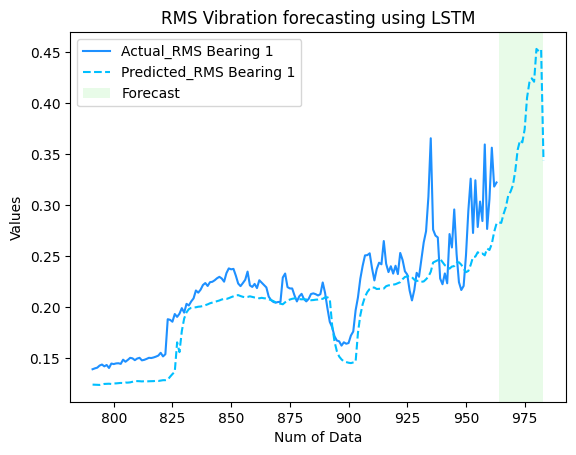

In [ ]:
plt.plot(d[['Actual_RMS Bearing 1']]
           [:highlight_start], label=['Actual_RMS Bearing 1'],color='dodgerblue')
plt.plot(d[['Predicted_RMS Bearing 1']]
         , label=['Predicted_RMS Bearing 1'], linestyle='--',color='deepskyblue')
plt.axvspan(d.index[highlight_start], d.index[highlight_end], facecolor='lightgreen', alpha=0.2, label='Forecast')

plt.title('RMS Vibration forecasting using LSTM')
plt.xlabel('Num of Data')
plt.ylabel('Values')
plt.legend()
plt.show()


#Plot RMS Forecast Bearing 2

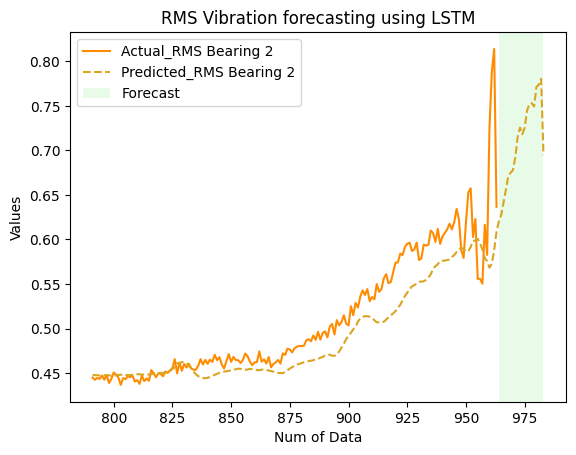

In [ ]:
plt.plot(d[['Actual_RMS Bearing 2']]
           [:highlight_start], label=['Actual_RMS Bearing 2'],color='darkorange')
plt.plot(d[['Predicted_RMS Bearing 2']]
         , label=['Predicted_RMS Bearing 2'], linestyle='--',color='goldenrod')
plt.axvspan(d.index[highlight_start], d.index[highlight_end], facecolor='lightgreen', alpha=0.2, label='Forecast')

plt.title('RMS Vibration forecasting using LSTM')
plt.xlabel('Num of Data')
plt.ylabel('Values')
plt.legend()
plt.show()


#Plot RMS Forecast Bearing 3

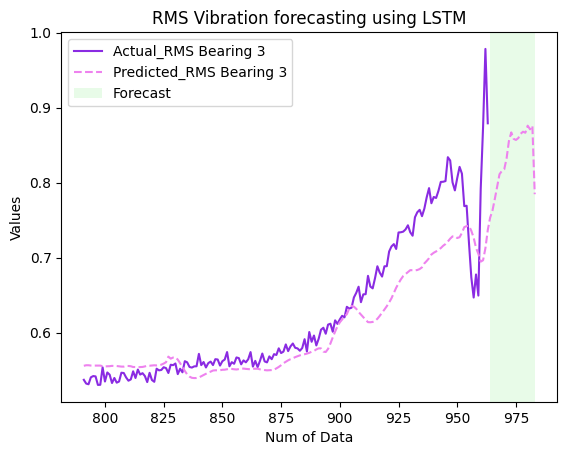

In [ ]:
plt.plot(d[['Actual_RMS Bearing 3']]
           [:highlight_start], label=['Actual_RMS Bearing 3'],color='blueviolet')
plt.plot(d[['Predicted_RMS Bearing 3']]
         , label=['Predicted_RMS Bearing 3'], linestyle='--',color='violet')
plt.axvspan(d.index[highlight_start], d.index[highlight_end], facecolor='lightgreen', alpha=0.2, label='Forecast')

plt.title('RMS Vibration forecasting using LSTM')
plt.xlabel('Num of Data')
plt.ylabel('Values')
plt.legend()
plt.show()


#Plot RMS Forecast Bearing 4

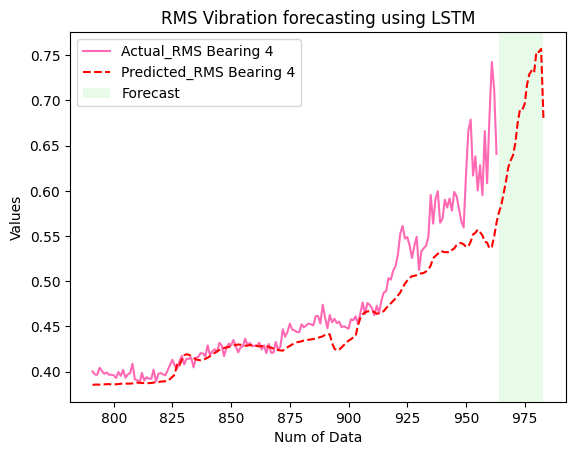

In [ ]:
plt.plot(d[['Actual_RMS Bearing 4']]
           [:highlight_start], label=['Actual_RMS Bearing 4'],color='hotpink')
plt.plot(d[['Predicted_RMS Bearing 4']]
         , label=['Predicted_RMS Bearing 4'], linestyle='--',color='red')
plt.axvspan(d.index[highlight_start], d.index[highlight_end], facecolor='lightgreen', alpha=0.2, label='Forecast')

plt.title('RMS Vibration forecasting using LSTM')
plt.xlabel('Num of Data')
plt.ylabel('Values')
plt.legend()
plt.show()

#Alert (send to E-mail)

In [ ]:
def send_email(sender_email, sender_password, receiver_email, subject, body):
    try:
        smtp_server = "smtp_server"
        smtp = smtplib.SMTP(smtp_server)
        # smtp.starttls()
        print(smtp)
        # smtp.login(sender_email, sender_password)

        message = MIMEMultipart()
        message["From"] = sender_email
        message["To"] = receiver_email
        message["Subject"] = subject
        html = """
<html>
<body>
    <h2> 🚨 <mark>warning</mark> </h2>
    <p>Dear Concerned Parties</p>
    <p>The system has detected that the machine's vibration level has exceeded the predefined threshold.</p>
    <h4>📍 Details</h4>

    </script>
    <ul>
       <li>Machine ID</li>
       <li>Production Line</li>
       <li>Time Deteced: {Time}</li>
       <li>Deteced Vibration Level: {Max_val:.2f} mm/s</li>
    </ul>
    <img src="{{ url_for('Rotating_machine', filename='Rotating_machine/RMS.png')}}" atl="RMS naaa">

</body>
</html>
"""
        html = html.format(Max_val=max, Time=time_s)
        message.attach(MIMEText(html, "html"))


        smtp.sendmail(sender_email, receiver_email, message.as_string())

        smtp.quit()

        print("Email send successfully!")

    except Exception as e:
        print(f"Error: {str(e)}")

if __name__ == "__main__":
    sender_email = "sender_email"
    sender_password = ""
    receiver_email = "receiver_email"
    subject = "subject"
    body = "This is a test email sent from Python"

    send_email(sender_email, sender_password, receiver_email, subject, body)